In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
if "/content/drive/My Drive/Machine Learning/lib/" not in sys.path:
    sys.path.append("/content/drive/My Drive/Machine Learning/lib/") 

In [0]:
from envs.windy_gridworld import WindyGridworldEnv
import plotting

import gym
import numpy as np
import itertools
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

## Sarsa方法
    

### 初始化环境

In [0]:
environment = WindyGridworldEnv()

In [6]:
# 这个环境中可能动作的个数
nA = environment.action_space.n
print(nA)

4


### 创建epsilon-greedy policy

$$
\pi(a|s)=
\left\{
    \begin{aligned}
        & \frac{\epsilon}{m}+1-\epsilon \quad if \; a*=argmax_{a \in A}(q(s,a)) \\
        & \frac{\epsilon}{m} \quad otherwise
    \end{aligned}
\right.
$$

In [0]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: 采取一个随机动作的概率.
        nA: 一个环境中可以采取的动作的个数(此时动作为离散的).
        times: 迭代的次数
    Returns:
        返回的是每一个动作出现的概率.
    
    """
    
    def policy_fn(observation):
        # 看到这个state之后, 采取不同action获得的累计奖励
        action_values = Q[observation]
        # 使用获得奖励最大的那个动作
        greedy_action = np.argmax(action_values)
        # 是的每个动作都有出现的可能性
        probabilities = np.ones(nA)/nA * epsilon
        # 最好的那个动作的概率会大一些
        probabilities[greedy_action] = probabilities[greedy_action] + (1 - epsilon)
        
        return probabilities
        
    return policy_fn 

###GLIE Monte-Carlo Control
- 在第k轮的迭代中(kth episode), 我们使用策略$\pi$得到了$\{S_{1}, A_{1}, R_{2}, \cdots, S_{T}\}$;
- 对于每一个状态$S$, 和动作$A$二元组, $\{S_{t}, A_{t}\}$, 我们进行如下操作(更新Q):
    - $N(S_{t}, A_{t}) \leftarrow N(S_{t}, A_{t}) + 1$, 出现次数+1;
    - $Q(S_{t}, A_{t}) \leftarrow Q(S_{t}, A_{t}) + \frac{1}{N(S_{t}, A_{t})} * (G_{t}-Q(S_{t}, A_{t}))$, 使用incremental mean;

更新策略, $\pi \leftarrow \epsilon-greedy(Q)$

### 评价一个策略的Q与更新策略

In [71]:
state = environment.reset()
environment.step(1)

(31, -1.0, False, {'prob': 1.0})

In [0]:
def GLIE(env, num_episodes, discount_factor=1.0, epsilon=0.2):
    # 环境中所有动作的数量
    nA = env.action_space.n

    # 初始化Q表
    Q = defaultdict(lambda: np.zeros(nA))

    # store the number of times each state is visited 
    returns_num = defaultdict(float)
    returns_sum = defaultdict(float) # 记录(state, action)对的累计reward
    
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes+1),
        episode_rewards=np.zeros(num_episodes+1)) 
    
    # 初始化police
    behaviour_policy = make_epsilon_greedy_policy(Q, epsilon, nA) # 这是我们实际执行采取的策略

    for i_episode in range(1, num_episodes + 1):
        # 开始一个episode, 开始一局游戏
        episode = [] # 这里包括((state,action,reward), (state,action,reward), ...)

        state = env.reset()        

        for t in itertools.count():
            action = np.random.choice(nA, p=behaviour_policy(state)) # 选择一个策略
            next_state, reward, done, _ = env.step(action) # 执行action, 返回reward和下一步的状态

            # 将状态加入episode中
            episode.append((state, action, reward))
            
            # 计算统计数据
            stats.episode_rewards[i_episode] += reward # 计算累计奖励
            stats.episode_lengths[i_episode] = t # 查看每一轮的时间

            if done or t>500:
                break

            state = next_state

        sa_in_episode = set([(x[0], x[1]) for x in episode]) # 只取出(state, action)
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # 找到第一次(state,action)出现的位置
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            # 第一次出现之后, 的累计的奖励
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_num[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_num[sa_pair]


        if i_episode % 100 == 0:
            # 打印
            print("\rEpisode {}/{}. | ".format(i_episode, num_episodes), end="")

    return Q, behaviour_policy, stats

### 评价上面的policy且进行可视化

In [176]:
Q, policy, stats = GLIE(environment, num_episodes=10000, discount_factor=0.9, epsilon=0.1)

Episode 10000/10000. | 

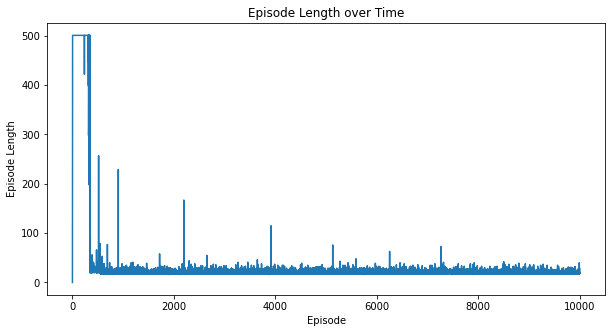

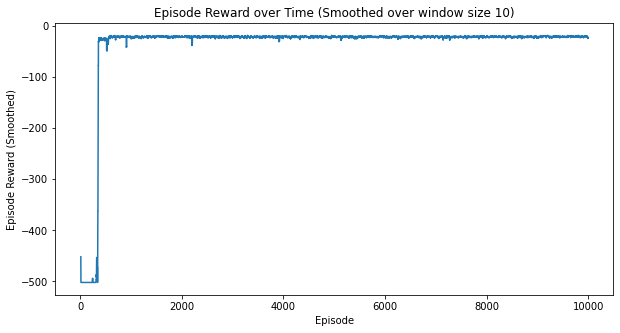

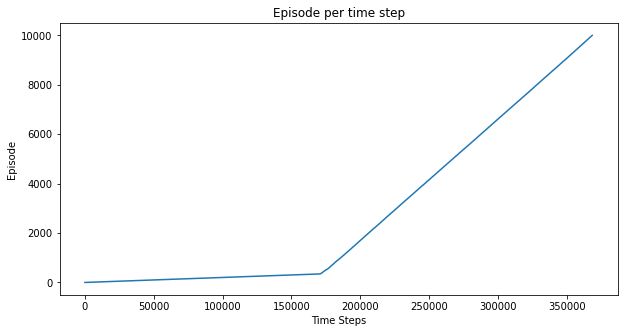

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [177]:
plotting.plot_episode_stats(stats)

In [178]:
state = environment.reset()
action = np.argmax(policy(state))

for t in itertools.count():
    state, reward, done, _ = environment.step(action) # 执行action, 返回reward和下一步的状态 
    action = np.argmax(policy(state)) # 查看新的action

    print('-Step:{}-(State, Action):({},{})'.format(t, state, action))
    environment._render() # 显示结果

    if done:
        break

    if t > 100:
        break

-Step:0-(State, Action):(40,1)
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

-Step:1-(State, Action):(41,1)
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

-Step:2-(State, Action):(42,1)
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

-Step:3-(State, Action):(43,0)
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

-Step:4-(State, Action):(23,0)
o  o  o  o  o  o  o  o  o  o
